In [1]:
import os

os.sys.path.insert(0, '/home/lagandua/projects/refining-skill-sequences/')

In [2]:
import numpy as np
from SkillsSequencing.skills.mps.dynsys.CLFDS import CLFDS
from SkillsSequencing.skills.mps.dynsys.WSAQF import WSAQF
from SkillsSequencing.skills.mps.dynsys.FNN import SimpleNN
from SkillsSequencing.skills.mps.dynsys.utils import plot_3d_trajectories
from SkillsSequencing.skills.mps.dynsys.CALVIN_DS import CALVINDynSysDataset
import torch
import matplotlib.pyplot as plt

pybullet build time: May 20 2022 19:45:31


In [3]:
dataset = CALVINDynSysDataset(skill='open_drawer', state_type='pos', train=True, goal_centered=False)

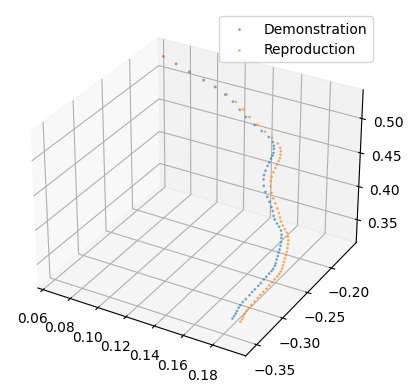

In [4]:
dataset.plot_random()

In [5]:
def get_skill_files(skill_name, state_type='pos'):
    clf = f'skills_ds/{state_type}/{skill_name}/clfds/clf'
    ds = f'skills_ds/{state_type}/{skill_name}/clfds/ds'
    return clf, ds

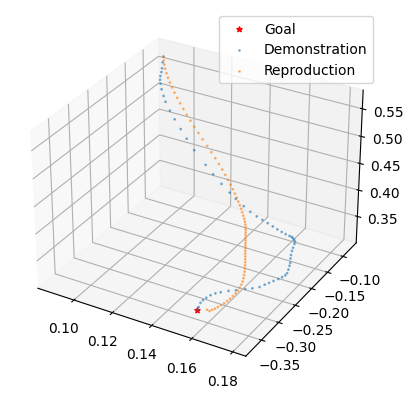

In [8]:
clf_file, reg_file = get_skill_files('open_drawer', 'pos')
clf_model = WSAQF(dim=3, n_qfcn=2)
reg_model = SimpleNN(3, 3, (20, 20))
ds = CLFDS(clf_model, reg_model, rho_0=0.1, kappa_0=0.0001)
ds.load_models(clf_file=clf_file, reg_file=reg_file)

max_steps = 70

rand_idx = np.random.randint(len(dataset.X))
x0 = dataset.X[rand_idx,0,:].numpy()
goal = dataset.X[rand_idx,-1,:].numpy()
x = x0
sampled_path = []
sampling_dt = 0.033
for step in range(max_steps):
    sampled_path.append(x)
    d_x = ds.reg_model.forward(torch.from_numpy(x-goal).float().unsqueeze(dim=0).unsqueeze(dim=0))
    d_x = d_x.detach().cpu().numpy().squeeze()
    delta_x = sampling_dt * d_x
    x = x + delta_x
    # if np.linalg.norm(x-goal) <= 0.01:
    #         break

plot_3d_trajectories(demos=dataset.X[rand_idx,:,:].numpy(), repro=np.array(sampled_path), goal=goal)